# Exploration of histone marks signal

In this notebook, we explore the data extracted from different histone marks and their relationship with loops.

In [4]:
import yaml
import pickle
import numpy as np
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, LeaveOneOut
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import leaves_list, linkage
from seqloops.config import features

In [5]:
loops = pickle.load(open(features, 'rb'))
loops.head()

,chrom,start,end,status,h3k18ac,h4k20me,h3k4me,scc1pk9,h3k79me,h4r3me2s,...,h3k4ac,h4r3me,htz1,h3k23ac,h2as129ph,seq,embedding,GC,GC_bias,entropy
0,chr1,169900,170100,0,"[0.018396200612187386, 0.005050189793109894, -...","[0.2289319932460785, 0.25649699568748474, 0.28...","[0.25578999519348145, 0.2653470039367676, 0.27...","[0.3869369924068451, 0.41925498843193054, 0.45...","[0.20388400554656982, 0.1845880001783371, 0.17...","[0.39266398549079895, 0.4145430028438568, 0.43...",...,"[0.04227619990706444, 0.014301899820566177, -0...","[0.029036400839686394, 0.01517259981483221, 0....","[0.4431940019130707, 0.456618994474411, 0.4685...","[-0.12232500314712524, -0.14110399782657623, -...","[0.037558600306510925, 0.0480601005256176, 0.0...",CTGCCCAGGCCGCTGAGCTGGTGGGTGAAGATTTGTCACGTAGAGT...,"[0.025517622190010216, 0.037476304228120066, 0...",0.467662,0.127660,1.375132
1,chr1,105900,106100,0,"[0.6587769985198975, 0.6518610119819641, 0.646...","[0.07989790290594101, 0.08233310282230377, 0.0...","[-0.7484800219535828, -0.748540997505188, -0.7...","[-0.24316400289535522, -0.2544490098953247, -0...","[0.05129830166697502, 0.04487119987607002, 0.0...","[-0.29708200693130493, -0.2942360043525696, -0...",...,"[0.6178950071334839, 0.602662980556488, 0.5811...","[0.4237169921398163, 0.4165180027484894, 0.405...","[0.6758750081062317, 0.6918389797210693, 0.711...","[0.12875600159168243, 0.1176069974899292, 0.10...","[-0.5438410043716431, -0.516414999961853, -0.4...",TAGAGGCTATGTAAAGCAAACAAAAAGGTTCGCGTAAATCAACGAG...,"[0.053078036369489774, 0.032007180227498926, -...",0.338308,0.294118,1.304473
2,chr1,67900,68100,0,"[1.7356300354003906, 1.7038500308990479, 1.680...","[-0.47108200192451477, -0.4556429982185364, -0...","[-0.5093410015106201, -0.432015985250473, -0.3...","[-1.3898600339889526, -1.3853100538253784, -1....","[-1.3136299848556519, -1.3405100107192993, -1....","[-0.11023999750614166, -0.17176499962806702, -...",...,"[0.5050839781761169, 0.5265690088272095, 0.548...","[0.9610480070114136, 1.0073699951171875, 1.057...","[-1.4965699911117554, -1.4635900259017944, -1....","[1.1223499774932861, 1.1261099576950073, 1.143...","[-1.1573899984359741, -1.1518199443817139, -1....",AAGAAAATGTTTAAGAAGAAGATTAAAAGCTCGAGGAAAGTACAGA...,"[0.022928485126398942, 0.035762054023935515, 0...",0.338308,0.352941,1.276310
3,chr1,187900,188100,0,"[0.36681699752807617, 0.35038599371910095, 0.3...","[0.743893027305603, 0.7365220189094543, 0.7288...","[-0.38534900546073914, -0.4125109910964966, -0...","[0.4498409926891327, 0.44080600142478943, 0.43...","[1.19937002658844, 1.218400001525879, 1.224679...","[-0.1602340042591095, -0.11332300305366516, -0...",...,"[0.6459190249443054, 0.5871300101280212, 0.537...","[0.5811439752578735, 0.6052349805831909, 0.617...","[0.649524986743927, 0.6703410148620605, 0.6840...","[0.19336600601673126, 0.18911999464035034, 0.1...","[-0.9937700033187866, -0.9549319744110107, -0....",TACTTTGTTGTGACAAAGTAGCTCACTGCCTTATTATCACATTTTC...,"[0.0520249379650605, 0.030264031404592308, 0.0...",0.363184,0.041096,1.343080
4,chr1,41900,42100,0,"[-0.7540079951286316, -0.7774670124053955, -0....","[-0.06211769953370094, -0.03974990174174309, -...","[-0.6383399963378906, -0.6472190022468567, -0....","[0.6897749900817871, 0.673554003238678, 0.6622...","[0.09745869785547256, 0.11009199917316437, 0.1...","[0.26982399821281433, 0.25178998708724976, 0.2...",...,"[-0.9066150188446045, -0.9201920032501221, -0....","[-0.6835690140724182, -0.6388710141181946, -0....","[-0.6571189761161804, -0.6929060220718384, -0....","[0.3390519917011261, 0.30396899580955505, 0.25...","[-0.2267020046710968, -0.22808299958705902, -0...",AAAAGGCAGTTTTCAATGCTTTCACTTTGTAAACTTTGTTTAGTAG...,"[0.06128749180810921, 0.039751119424842975, 0....",0.263682,-0.132075,1.266637


In [26]:
loops.columns

Index(['chrom', 'start', 'end', 'status', 'h3k18ac', 'h4k20me', 'h3k4me',
       'scc1pk9', 'h3k79me', 'h4r3me2s', 'h3k36me2', 'h4k16ac', 'h4k12ac',
       'h3k27ac', 'h2ak5ac', 'h3k4me3', 'h4k8ac', 'h3k9ac', 'h3k36me3',
       'h3k56ac', 'h4k5ac', 'h3k4me2', 'h3k36me', 'h3k14ac', 'h3s10ph',
       'h3k79me3', 'h3k4ac', 'h4r3me', 'htz1', 'h3k23ac', 'h2as129ph', 'seq',
       'embedding', 'GC', 'GC_bias', 'entropy'],
      dtype='object')

In [68]:
# Selecting features to be used throughout the notebook
# NOTE: scc1pk9 was added as a control. It is the cohesin protein, known to be
# responsible for loops
histones = loops[[
    'h3k18ac', 'h4k20me', 'h3k4me',
    'h3k79me', 'h4r3me2s', 'h3k36me2',
    'h4k16ac', 'h4k12ac', 'h3k27ac',
    'h2ak5ac', 'h3k4me3', 'h4k8ac',
    'h3k9ac', 'h3k36me3', 'h3k56ac',
    'h4k5ac', 'h3k4me2', 'h3k36me',
    'h3k14ac', 'h3s10ph', 'h3k79me3',
    'h3k4ac', 'h4r3me', 'htz1',
    'h3k23ac', 'h2as129ph'
]]

marks = histones.columns
# marks = histones[['h3k36me3', 'htz1', 'h4r3me', 'h2as129ph']]
# Generate other features from the same histone marks
ops = [np.mean, np.ptp]
n_marks = len(marks)
X = pd.concat([histones.applymap(op) for op in ops], axis=1)
X.columns = [f'{m}_{op.__name__}' for op in ops for m in marks]
y = loops.status

A few histone marks such as H2as123ph, H3K4Me3 or H3K36Me3 stand out as different between loops and non loops.

Text(0, 0.5, 'Averaged mark intensity difference (loops - non-loops)')

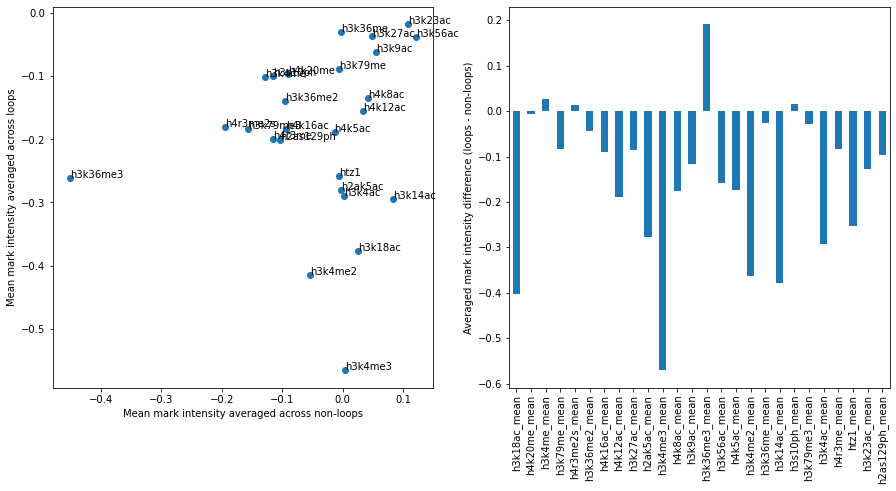

In [69]:
%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
#avg_loops = X.loc[loops.status == 1, :].mean(axis=0)
#avg_control = X.loc[loops.status == 0, :].mean(axis=0)
comp = pd.concat([X.iloc[:, :n_marks], y], axis=1).groupby('status').agg(np.mean).T
comp['ratio'] = comp[1] - comp[0]
ax[0].scatter(comp[0], comp[1])
ax[0].set_xlabel("Mean mark intensity averaged across non-loops")
ax[0].set_ylabel("Mean mark intensity averaged across loops")

for i, mark in enumerate(marks):
    ax[0].annotate(mark, (comp.iloc[i, 0], comp.iloc[i, 1]))


comp['ratio'].plot.bar(ax=ax[1])
ax[1].set_ylabel('Averaged mark intensity difference (loops - non-loops)')

We'll compute a few summary statistics of histone coverage for each sequence and use these as features.

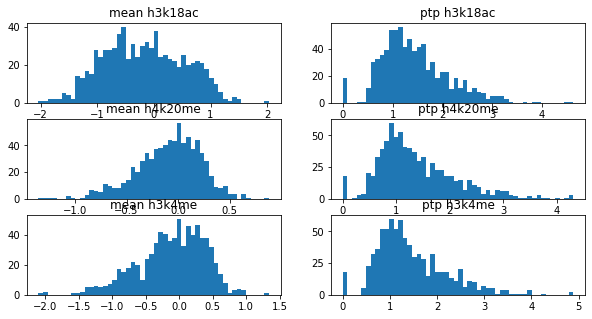

In [70]:
%matplotlib inline
# Checking the distribution of new features
sel_marks = 3
fig, ax = plt.subplots(sel_marks, len(ops), figsize=(5*len(ops), 5))
for i, op in enumerate(ops):
    mark_idx = [x + i * n_marks for x in range(sel_marks)]
    for j, idx in enumerate(mark_idx):
        if len(ops) > 1:
            a = ax[j, i]
        else:
            a = ax[j]
        a.hist(X.iloc[:, idx], 50)
        a.set_title(f'{op.__name__} {marks[j]}')
plt.show()

If we visualize the feature matrix and cluster rows (sequences) by similarity, we see a group of weird identical sequences. These may be some sort of sampling artifact (maybe resampling the same anchor many times ?).

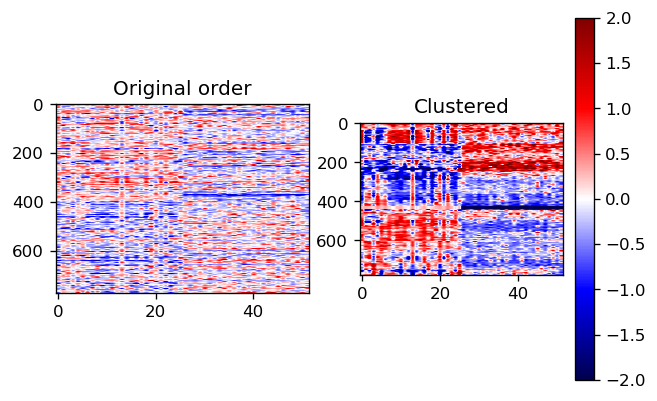

In [71]:
%matplotlib inline

fig, ax = plt.subplots(1, 2, dpi=120)
ss = StandardScaler()
x_scaled = ss.fit_transform(X)
Z = linkage(x_scaled, 'ward')
im = ax[0].imshow(x_scaled, aspect=0.05, cmap='seismic', vmax=2, vmin=-2)
ax[1].imshow(x_scaled[leaves_list(Z), :], aspect=0.05, cmap='seismic', vmax=2, vmin=-2)
ax[0].set_title("Original order")
ax[1].set_title("Clustered")
plt.colorbar(im)

If we reduce the number of features using PCA, we can kind of see two equally sized groups emerge.

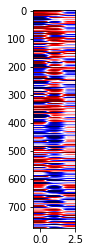

In [72]:
%matplotlib inline

pca = PCA(n_components=3)
pcs = pca.fit_transform(x_scaled)
plt.imshow(pcs, aspect=0.02,cmap='seismic', vmax=2, vmin=-2)

There is not any single feature that completely separate the groups, but most the distributions of most features are different between the two.

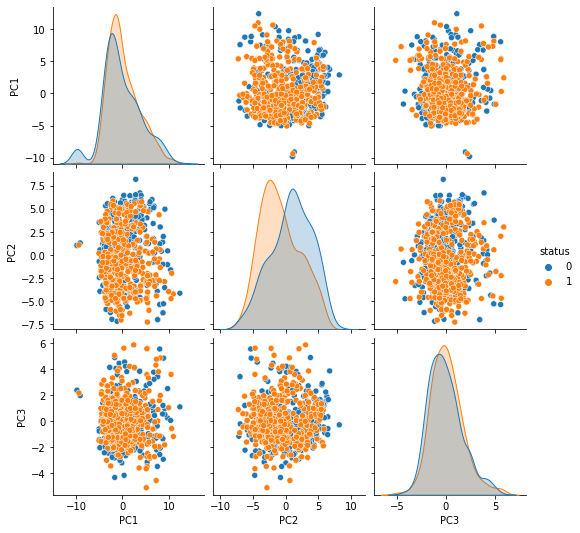

In [73]:
%matplotlib inline

pcs_df = pd.DataFrame(pcs[:, :5])
pcs_df.columns = [f'PC{i+1}' for i in range(pcs_df.shape[1])]
pcs_df['status'] = y.values
sns.pairplot(data=pcs_df, hue='status')

I don't use any preprocessing as feature selection and preprocessing only reduced performance. That makes sense, RF basically do feature selection when selecting splits, and rely on ranks.

In [74]:
import yaml
# Random forests rely on ranks, no need to standardize
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
pl = Pipeline([
    ('forest', RandomForestClassifier())]
)
# Search for optimal parameters (uses 5-fold cv for validation by default)
params = {
    'forest__n_estimators': [50, 100, 200, 300],
    'forest__max_depth': [10, 30, 50, None],
}
gs = GridSearchCV(pl, param_grid=params, verbose=True, n_jobs=12)
gs.fit(X, y)
print(
    f"Obtained a best accuracy of {gs.best_score_:.2f} "
    f"with the following parameters: \n{yaml.dump(gs.best_params_)}"
)
pl.set_params(**gs.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Obtained a best accuracy of 0.70 with the following parameters: 
forest__max_depth: 30
forest__n_estimators: 200



Pipeline(steps=[('forest',
                 RandomForestClassifier(max_depth=30, n_estimators=200))])

<AxesSubplot:ylabel='Frequency'>

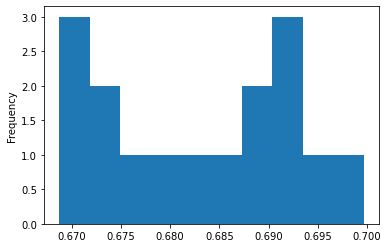

In [75]:
pd.DataFrame(gs.cv_results_).mean_test_score.plot(kind='hist')

Validating results on LOO CV, since the dataset is pretty small.

In [76]:

loo = LeaveOneOut()
correct = 0
preds = []
x = X.to_numpy()
pl.set_params(**gs.best_params_)
for train_idx, test_idx in tqdm.tqdm(loo.split(x), unit='sample', total=x.shape[0]):
    X_train, X_test = x[train_idx], x[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    pl.fit(X_train, y_train)
    preds.append(pl.predict(X_test))



100%|██████████| 776/776 [08:11<00:00,  1.58sample/s]


In [77]:
print(accuracy_score(y, preds))

0.6804123711340206


In [78]:
pl.fit(X, y)
importances = pl.named_steps['forest'].feature_importances_
order = np.argsort(importances)
for mark, imp in zip(X.columns[order], importances[order]):
    print(f"{mark}: {imp}")

h3k36me2_ptp: 0.011899236257506931
h3k36me_ptp: 0.013345771577245183
h3k79me3_ptp: 0.013673448029339574
h4r3me_ptp: 0.01395094263150293
h4r3me2s_ptp: 0.013955555097237783
h4k12ac_ptp: 0.014259673122295083
h3k4me_ptp: 0.014288061254795358
h3k36me3_ptp: 0.014424848626639153
h3k4me2_ptp: 0.014556569069481379
h3k4ac_ptp: 0.014565996357984326
h3k14ac_ptp: 0.01471664118756736
h3k56ac_ptp: 0.014737215945645742
h3k23ac_ptp: 0.014904125809357677
h3k4me3_ptp: 0.014975958527871942
h3k27ac_ptp: 0.015036350764650827
h3k79me_ptp: 0.015081663688950895
htz1_ptp: 0.015171412767279372
h4k20me_ptp: 0.015302315488716217
h3k18ac_ptp: 0.015569337541984033
h2as129ph_ptp: 0.015591170235422816
h2ak5ac_ptp: 0.01597429935801048
h4k8ac_mean: 0.016089508703178768
h3k27ac_mean: 0.01672544682779413
h3s10ph_ptp: 0.017037740316315216
h3k4me_mean: 0.017054993827421903
h3k9ac_ptp: 0.01712835315582235
h4k5ac_ptp: 0.017335696536241847
h3k56ac_mean: 0.0175123781635704
h3k36me2_mean: 0.01766446104337067
h4k16ac_ptp: 0.01777

In [79]:
# rbf SVC performs marginally better, but is less interpretable
X_train, X_test, y_train, y_test = train_test_split(X, loops['status'], test_size=0.20)
pl = Pipeline([
    ('select', SelectKBest(f_classif)),
    ('scale', StandardScaler()),
    ('svc', SVC())]
)
# Search for optimal parameters (uses 5-fold cv for validation by default)
params = {
    'select__k': [2, 5, 10, 20, 'all'],
    'svc__gamma': ['scale', 'auto'],
    'svc__kernel': ['linear', 'rbf'],
}
gs = GridSearchCV(pl, param_grid=params, verbose=True, n_jobs=12)
gs.fit(X, y)
print(
    f"Obtained a best accuracy of {gs.best_score_:.2f} "
    f"with the following parameters: \n{yaml.dump(gs.best_params_)}"
)
pl.set_params(**gs.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Obtained a best accuracy of 0.71 with the following parameters: 
select__k: all
svc__gamma: scale
svc__kernel: rbf



Pipeline(steps=[('select', SelectKBest(k='all')), ('scale', StandardScaler()),
                ('svc', SVC())])

Side note: When adding cohesin to the features, the SVC pipeline get the best result (acc=0.88) by keeping only 2 features: scc1pk9, h3k4me3